In [20]:
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/src/'
sys.path.insert(0, src_dir)

# import prototype_GRB_population as pt
from GRB_population import GRBPopulation
import physics as ph
import numpy as np
import io_grb_pop as io
import miscellaneous as msc
from cosmology import init_cosmology
from ECLAIRs import init_ECLAIRs
import observational_constraints as obs
# General imports
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('paper')

In [21]:
paths_to_dir, paths_to_files = io.generate_paths()
paths_to_files['config'] = paths_to_files['config'].parent / 'config_simple_example.yml'
paths_to_files['config']

PosixPath('/Users/palmerio/Science_projects/GRB_population_model/init/config_simple_example.yml')

In [22]:
config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)

In [23]:
cosmo = init_cosmology(paths_to_dir['cosmo'])
ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                            Emin=instruments['ECLAIRs']['Emin'],
                            Emax=instruments['ECLAIRs']['Emax'],
                            n_sigma=instruments['ECLAIRs']['n_sigma'])
samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

Nb_GRBs = int(float(config['Nb_GRBs']))

incl_samples, incl_instruments, incl_constraints = msc.create_config(config=config,
                                                       samples=samples,
                                                       instruments=instruments,
                                                       obs_constraints=obs_constraints)

In [24]:
np.random.seed(0)
GRB_pop = GRBPopulation(Nb_GRBs=int(float(config['Nb_GRBs'])),
                        output_dir=paths_to_dir['output'])

In [25]:
GRB_pop.draw_GRB_properties(cosmo=cosmo, params=params)
GRB_pop.calc_peak_photon_flux(incl_instruments)

In [26]:
GRB_pop.properties

,z,L,Ep,t90obs,Cvar,alpha,beta,ktild,D_L,Epobs,Eiso,t90,pht_pflx_BATSE,pht_pflx_BAT
0,2.488,8.709831e+50,1075.674179,75.525730,0.152786,1.160800,2.93920,0.679770,20580.690742,308.392826,2.881462e+51,21.653019,0.034844,0.064038
1,3.057,1.396389e+52,164.092569,25.145532,0.427214,-0.243010,2.17167,1.368446,26443.739383,40.446776,3.697493e+52,6.198061,0.219963,0.708167
2,2.645,7.907064e+50,220.058949,8.398272,0.350519,0.433020,2.78338,1.732037,22177.953974,60.372825,6.385864e+50,2.304053,0.040646,0.123207
3,2.477,2.190679e+50,127.161189,61.179481,0.176116,0.704579,2.42682,0.927766,20469.423445,36.572099,6.788579e+50,17.595479,0.008355,0.035325
4,2.185,7.639785e+50,116.639918,61.894119,0.239741,0.586753,4.04809,1.777380,17549.217070,36.621638,3.559286e+51,19.433004,0.045731,0.268695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3.104,5.495233e+50,1270.212849,200.816376,0.082878,0.494334,2.47726,1.269656,26936.575471,309.506055,2.228516e+51,48.931866,0.009266,0.011019
99996,2.380,3.701583e+50,1351.154396,15.632354,0.431893,0.389676,2.93920,1.953963,19492.065259,399.749821,7.393863e+50,4.624957,0.012360,0.012719
99997,3.562,3.847032e+50,8231.678053,9.044525,0.176714,0.770485,2.21977,0.557739,31797.513066,1804.401152,1.347804e+50,1.982579,0.000541,0.000594
99998,2.494,3.712766e+50,842.340649,25.825846,0.133955,0.478409,2.54189,1.384925,20641.418411,241.082040,3.676099e+50,7.391484,0.013854,0.017948


In [27]:
GRB_pop.calc_det_prob(incl_samples=incl_samples)

In [28]:
cond = GRB_pop.properties['pdet_EpGBM'] == 1
z_med_GBM = np.median(GRB_pop.properties[cond]['z'])
z_med_GBM

1.66

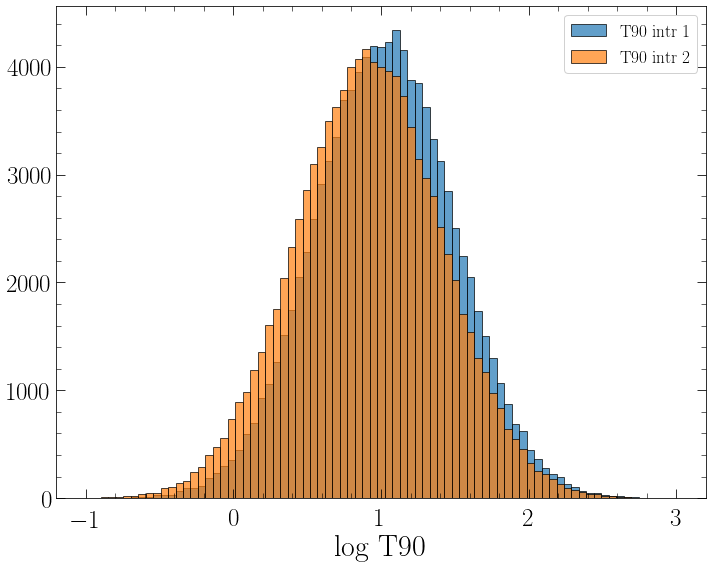

In [31]:
# Conclusion: It's better to do method 1 where we divide the observed T90 distribution by the mean redshift
# of the GBM_bright population and then draw from that.
# This is valid even for dimmer bursts than the ones of GBM_bright if we assume there is no correlation between 
# pflx and T90 (which there doesn't seem to be).
# Otherwise the problem with method 2 where we draw from the observed T90 distribution and assign it a redshift
# from the whole LGRB population is that you get some T90s that are assigned a very high redshift which in
# practice would make them undetectable in GBM_bright. This overestimation of the redshift leads to a bias towards
# lower T90_intr since T90_intr = T90_obs / (1+z). This is all illustrated in the figure below

t90intr_1 = np.random.normal(1.45-np.log10(1+z_med_GBM), 0.47, Nb_GRBs)
t90intr_2 = np.log10(GRB_pop.properties['t90'])
bins_z = np.linspace(-1,3,80)
plt.figure(figsize=(10,8))
plt.hist(t90intr_1, bins=bins_z, label='T90 intr 1', alpha=0.7)
plt.hist(t90intr_2, bins=bins_z, label='T90 intr 2', alpha=0.7)
plt.legend()
plt.xlabel('log T90')
plt.show()